 All used libraries are imported in the following code block.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd
import seaborn as sns
import colorcet as cc
import fsspec
import math
import scipy.stats as stats

import matplotlib.pyplot as plt


In [2]:
# Reading in the previously cleaned data
data = pd.read_csv('cleaned_data/cleaned.csv')
data.head(5)

,source_airline_country,source_airport_ID,source_airport_name,source_airport_city,source_airport_country,source_airport_lat,source_airport_long,source_airport_alt,destination_airport_ID,destination_airport_name,...,destination_airport_alt,airline_ID,airline_name,route_stops,IATA Code,icao_code,aircraft_name,aircraft_general_make,aircraft_company,airbus_boeing_other
0,Portugal,2965.0,Sochi International Airport,Sochi,Russia,43.449902,39.956600,89.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
1,Portugal,2966.0,Astrakhan Airport,Astrakhan,Russia,46.283298,48.006302,-65.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
2,Portugal,2966.0,Astrakhan Airport,Astrakhan,Russia,46.283298,48.006302,-65.0,2962.0,Mineralnyye Vody Airport,...,1054.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
3,Portugal,2968.0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,55.305801,61.503300,769.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
4,Portugal,2968.0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,55.305801,61.503300,769.0,4078.0,Tolmachevo Airport,...,365.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other


Below are some useful definitions that will be used later in the analysis of the data.

In [3]:
def linear_regression(data, features, target):
    X = data[features]
    y = data[target]

    model = LinearRegression()

    model.fit(X, y)

    coefficients = model.coef_
    intercept = model.intercept_
    r_squared = model.score(X, y)

    print("Coefficients", coefficients)
    print("Intercept", intercept)
    print("R-Squared", r_squared)

    return coefficients, intercept, r_squared

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Radius of the Earth in kilometers
    radius = 6371 
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c
    
    return distance

def t_test(group1, group2):
    t_statistic, p_value = stats.ttest_ind(group1, group2)
    # Print the results
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)

    # Interpret the results
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the groups.")
    return t_statistic, p_value


Below are some definitions for basic visuals that can be used.

In [4]:
def stacked_bar_chart(data, title=None, xlabel=None, ylabel=None, legend_labels=None):

    # Create figure and axis
    fig, ax = plt.subplots()

    data.plot(kind='bar', stacked=True, ax=ax, color = sns.color_palette(cc.glasbey_hv))

    # Add title, label, legend
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if legend_labels:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    return fig

def create_colored_world_map(data, country_col, feature, legend_title ='Aircraft Company',
                              title="World Map Colored by Most Used Aircraft Company"):

    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/" \
      "download/110m/cultural/ne_110m_admin_0_countries.zip"
    
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)

    # Changing the world dataset to have the same Country names as the cleaned dataset.
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("United States of America","United States")
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Democratic Republic of the Congo","Republic of the Congo",)
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Congo - Kinshasa","Congo (Kinshasa)")
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Czech Republic","Czech Republic")

    world = world.merge(data, left_on='SOVEREIGNT', right_on=country_col)
    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=1, color='k')
    palette = sns.color_palette(cc.glasbey_hv)

    legend_artists = []
    legend_labels = []

    for i, company in enumerate(world[feature].unique()):
        subset = world[world[feature] == company]
        subset.plot(ax=ax, color=palette[i], label=company)

        legend_artists.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10))
        legend_labels.append(company)

    ax.legend(legend_artists, legend_labels, title = legend_title, loc='lower left')

    ax.set_title(title)


    return fig

def create_histograms(data, category_column, value_column, bins=10, colors=None, title=None, xlabel=None, ylabel=None, same_axes=False):
    # If colors are not provided, use a default list of colors
    if colors is None:
        colors = sns.color_palette(cc.glasbey_hv)

    # Get unique categories (aircraft companies)
    categories = data[category_column].unique()
    total_frequencies = data[category_column].value_counts()

    categories = sorted(categories, key=lambda category: -total_frequencies[category])

    # Calculate the number of rows and columns for subplots
    num_rows = (len(categories) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2  # Number of columns per row

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    # Plot histograms for each category (aircraft company) on separate axes
    for i, category in enumerate(categories):
        row, col = i // num_cols, i % num_cols
        color = colors[i % len(colors)]
        category_data = data[data[category_column] == category]

        if same_axes:
            # Compute shared x and y limits
            min_value = min(data[value_column].min(), category_data[value_column].min())
            max_value = max(data[value_column].max(), category_data[value_column].max())
            min_y = 0  # Y-axis starts from 0
            max_y = 7000


            # Plot the histogram with shared axes
            axes[row, col].hist(category_data[value_column], bins=bins, color=color)
            axes[row, col].set_xlim(min_value, max_value)
            axes[row, col].set_ylim(min_y, max_y)
            
        else:
            # Plot the histogram with default axes
            axes[row, col].hist(category_data[value_column], bins=bins, color=color)


        axes[row, col].hist(category_data[value_column], bins=bins, color=color)
        axes[row, col].set_title(category)

        total_frequency = total_frequencies[category]
        axes[row, col].text(0.8, 0.8, f'Total: {total_frequency}', transform=axes[row, col].transAxes,
                            bbox=dict(facecolor='white'))

    # Add common title and labels
    if title:
        fig.suptitle(title, fontsize = 16)
    if xlabel:
        for ax in axes[-1, :]:
            ax.set_xlabel(xlabel)
    if ylabel:
        for ax in axes[:, 0]:
            ax.set_ylabel(ylabel)

    return fig

def create_scatterplot(data, x_column, y_column, hue_column, palette=None, title=None, legend_title=None, 
                       xlabel=None, ylabel=None, top_n=4):
    # Define a color palette if not provided
    if palette is None:
        palette = sns.color_palette(cc.glasbey_hv, n_colors=len(data))

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    scatterplot = sns.scatterplot(data=data, x=x_column, y=y_column, hue=hue_column, palette=palette)
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    
    correlation = data[x_column].corr(data[y_column])

    # Add the correlation value as a text annotation
    plt.annotate(f'Pearson Correlation: {correlation:.2f}', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)

    # Add a legend
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    data_sorted = data.sort_values(by=y_column, ascending=False)
    for index, row in data_sorted.head(top_n).iterrows():
        # Shift the annotation to the right (adjust the values as needed)
        x_shift, y_shift = 15, 7
        plt.annotate(row[hue_column], (row[x_column] + x_shift, row[y_column] + y_shift), fontsize=10)


    return plt

The data includes the latitude and longitude position of each of the airports for each route. To find the lengths of the routes travelled and add it to the dataset, we can use the Haversine formula as was defined above.

In [5]:
data['distance'] = data.apply(lambda row: haversine_distance(row['source_airport_lat'], 
                                                             row['source_airport_long'], 
                                                             row['destination_airport_lat'], 
                                                             row['destination_airport_long']), axis=1)

To start exploring the data with basic visualizations, we can used a stacked bar chart to see, based on the number of routes traveled, what the top 5 airines are. Within each airline, the bars will represent what quantity of their routes traveled are completed with different aircraft company's equipment. 

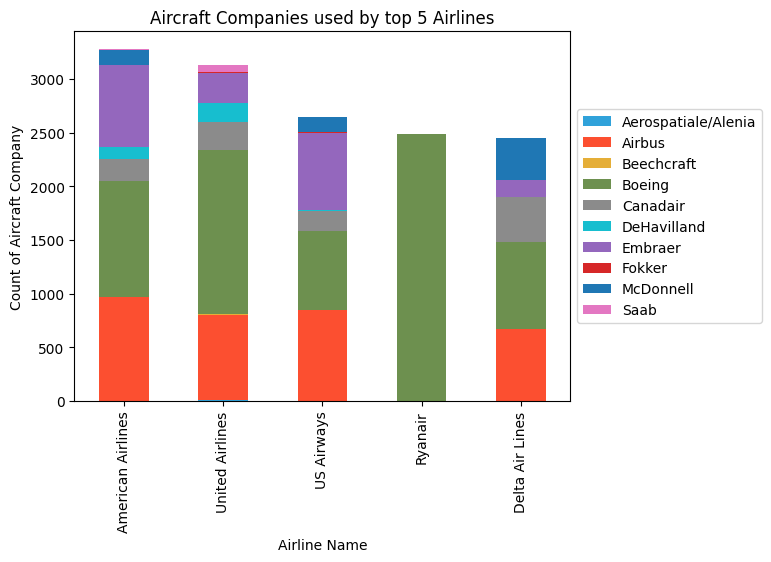

In [6]:
# Pivot the DataFrame to get counts of 'aircraft' per 'airline'
pivot_df = data.pivot_table(index='airline_name', columns='aircraft_company', aggfunc='size', fill_value=0)
# Calculate the total count of routes for each airline
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort the DataFrame by the total count in descending order
pivot_df = pivot_df.sort_values(by='Total', ascending=False)
pivot_df = pivot_df.head(5)
pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]


fig = stacked_bar_chart(pivot_df.drop(columns='Total'), xlabel='Airline Name', ylabel='Count of Aircraft Company', 
                        title='Aircraft Companies used by top 5 Airlines', legend_labels='Aircraft Company')
plt.show()

As shown by the bar charts above. The airline companies with the most routes are American Airlines, United Airlines, US Airways, Ryanair, and Delta Airlines. Within these companies, it's clear that they favor equipment from Boeing and Airbus. An interesting outlier is that Ryanair exclusively uses Boeing aircrafts, whereas the rest of the top airlines seem to have a similar mix of aicraft types.

Another interesting thing to explore about the data would be if there are regions of the world that favor different aircraft companies. The visual below shows which aircraft companies are favored based on the highest quanitity of routes originating in each country with that aircraft type.

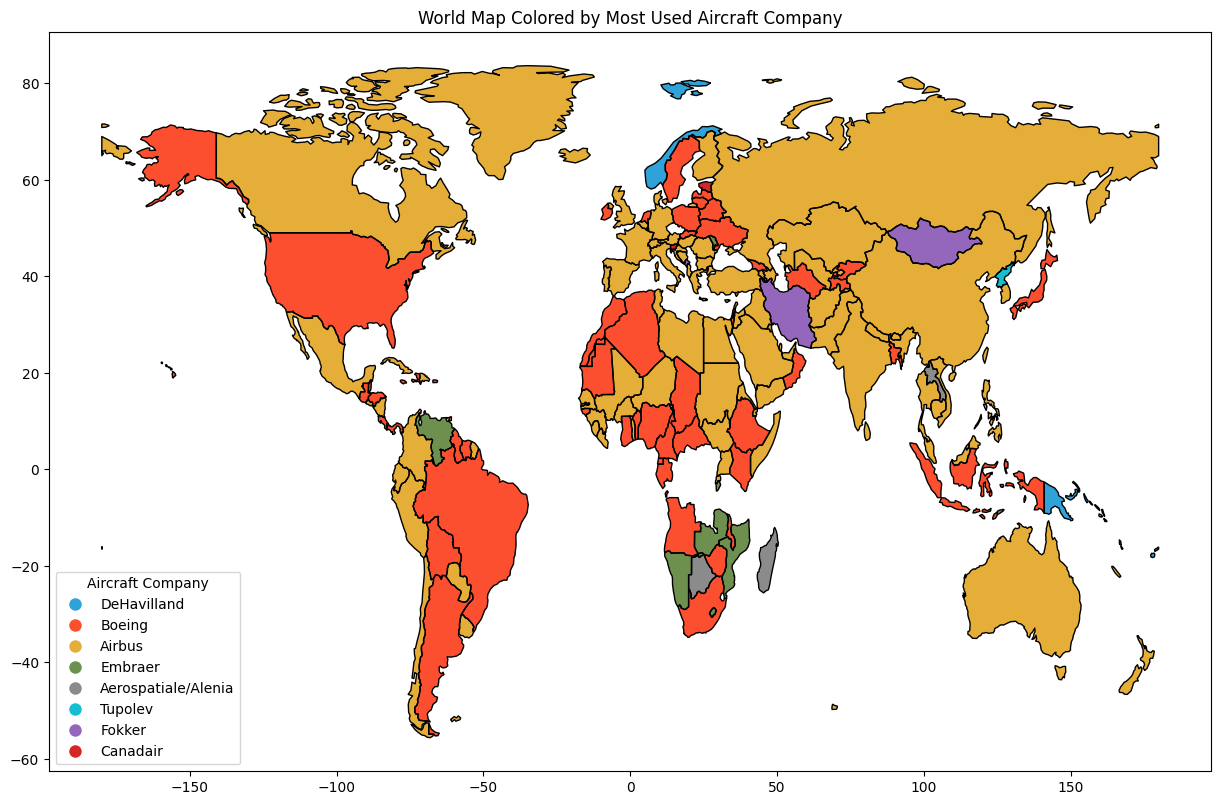

In [7]:
pivot_df = data.pivot_table(index='source_airport_country', columns='aircraft_company', aggfunc='size', fill_value=0)
pivot_df['MostUsedCompany'] = pivot_df.idxmax(axis=1)
pivot_df = pivot_df.reset_index()

create_colored_world_map(pivot_df, country_col='source_airport_country', feature='MostUsedCompany', legend_title ='Aircraft Company',
                         title="World Map Colored by Most Used Aircraft Company")
plt.show()


Similarly to what was discovered with the bar charts, it's clear that Boeing and Airbus are typically favored globally. This leads to the next question. What is the distribution of distances of the routes traveled depending on aircraft type? The visualization below shows the top 6 aircraft companies by number of unique routes traveled, and what those distances are.

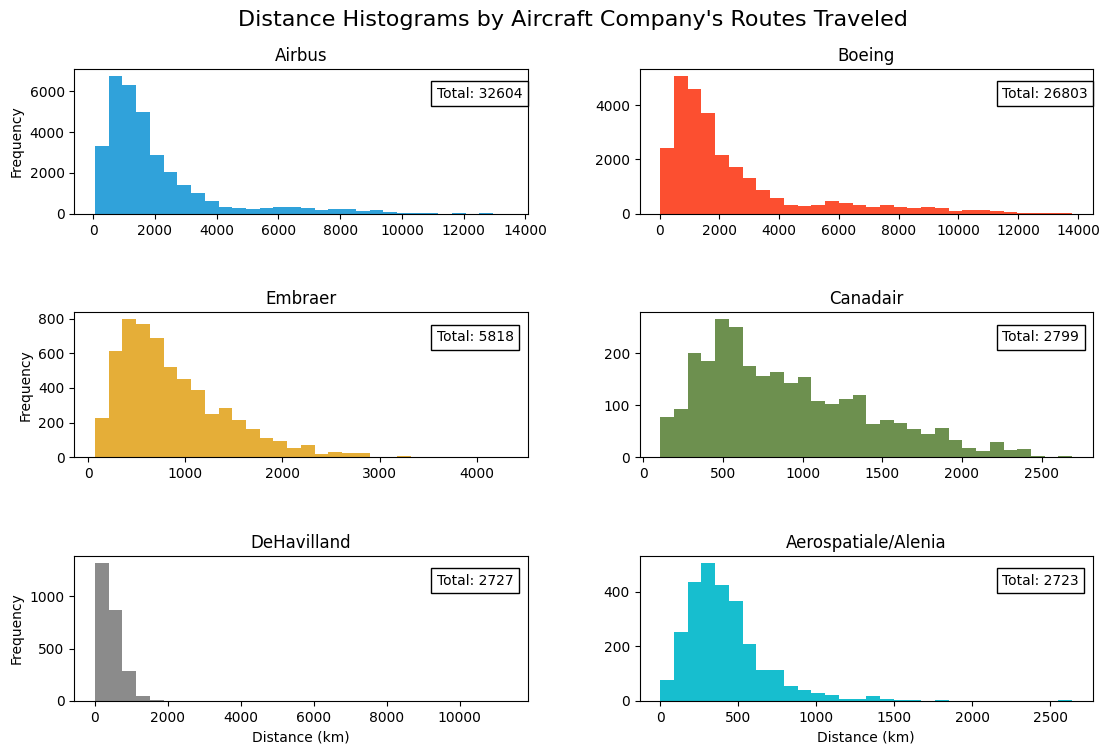

In [8]:
top_airlines = data['aircraft_company'].value_counts().nlargest(6).index

# Filter data to include only rows corresponding to the top airlines
filtered_data = data[data['aircraft_company'].isin(top_airlines)]

create_histograms(filtered_data, category_column='aircraft_company', value_column='distance', 
                  title="Distance Histograms by Aircraft Company's Routes Traveled", xlabel="Distance (km)", 
                  ylabel="Frequency", bins=30)
plt.show()

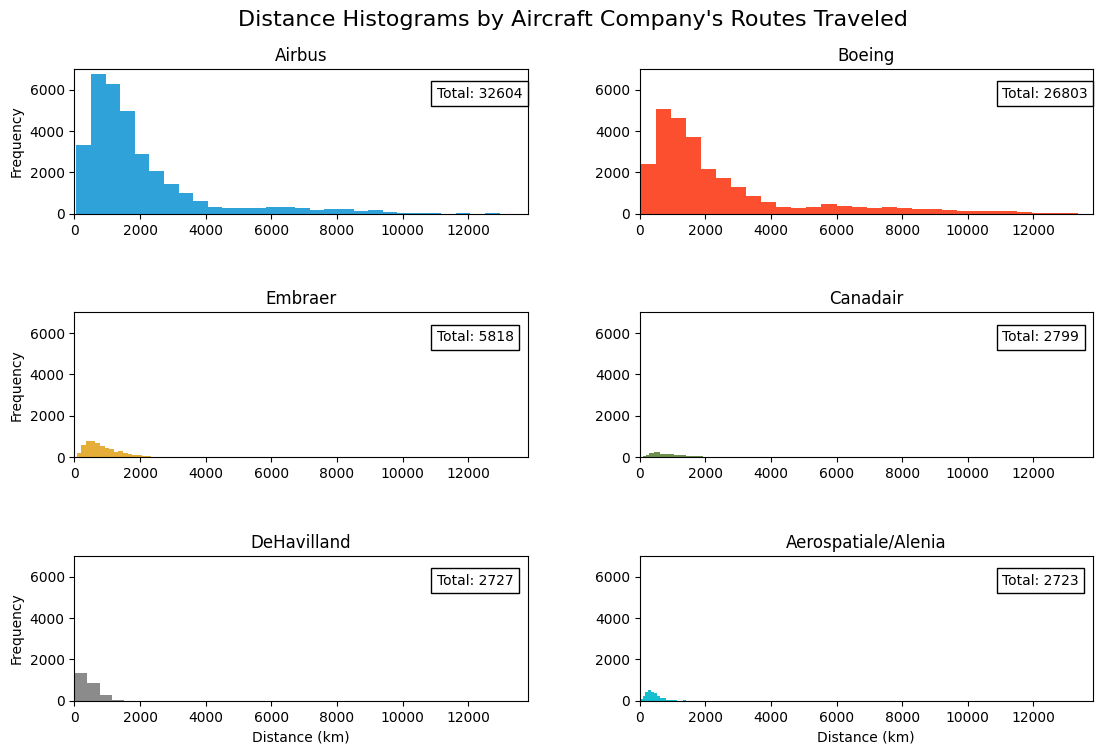

In [9]:
create_histograms(filtered_data, category_column='aircraft_company', value_column='distance', 
                  title="Distance Histograms by Aircraft Company's Routes Traveled", xlabel="Distance (km)", 
                  ylabel="Frequency", bins=30, same_axes=True)
plt.show()

Airbus and Boeing clearly have the largest number of unique routes, and have longer routes traveled compared to the other top aircraft companies. Seeing this as a potential trend, we will explore if there is a correlation between the number of routes an aircraft company has, and the average distance of those routes traveled.

Coefficients [0.03324911]
Intercept 473.8227269946581
R-Squared 0.3524716351385595


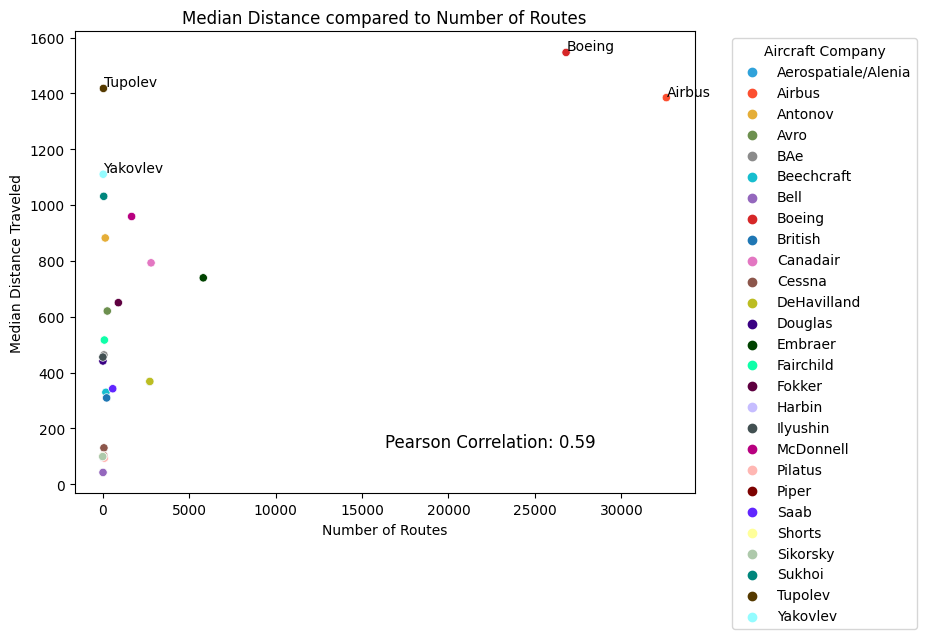

In [10]:
company_stats = data.groupby('aircraft_company').agg({'distance': 'median', 'aircraft_company': 'count'})
company_stats = company_stats.rename(columns={'distance': 'med_distance', 'aircraft_company': 'num_routes'}).reset_index()

features = ['num_routes']
target = 'med_distance'
coefficients, intercept, r_squared = linear_regression(company_stats, features, target)

dist_route_plt = create_scatterplot(data=company_stats, x_column='num_routes', y_column='med_distance', 
                   hue_column='aircraft_company', title='Median Distance compared to Number of Routes', 
                   legend_title='Aircraft Company', xlabel='Number of Routes', ylabel='Median Distance Traveled')

dist_route_plt.show()


The Pearson Correlation for the average distance of the routes flown by each aircraft company vs the number of routes traveled is 0.71. With a Pearson correlation coefficient of 0.59 and an R-squared value of 0.352, there is evidence of a moderate to strong positive linear relationship, and the linear regression model explains approximately 35.2% of the variability in the dependent variable.

Just by visual inspection, it seems like there is a possible logistic correlation instead of linear which was just tested. We'll investigate the possibility below. This will help us normalize the two outliers of Airbus and Boeing.

Coefficients [93.29679862]
Intercept 79.4341663706769
R-Squared 0.27321731396162086


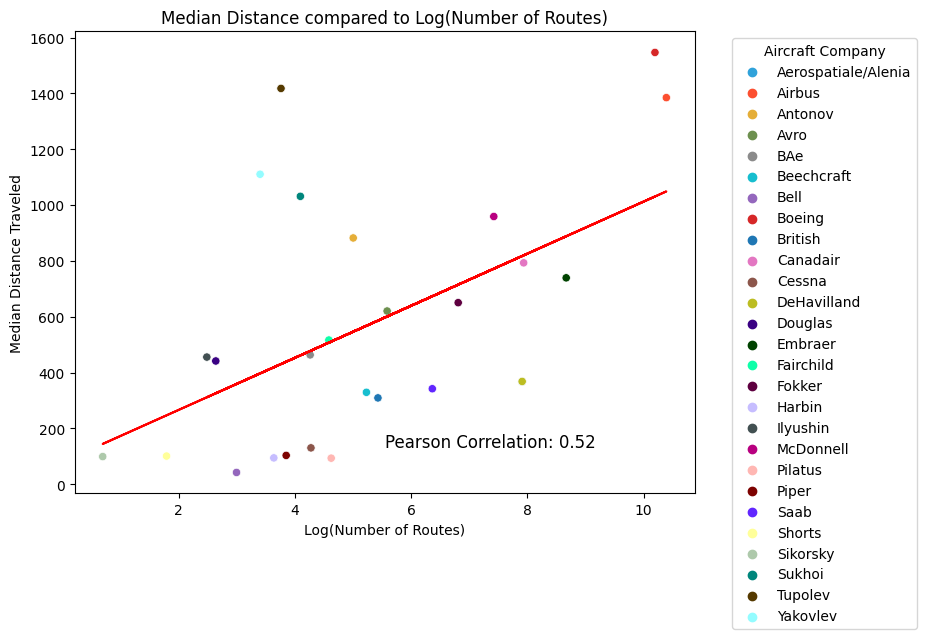

In [11]:
company_stats['num_routes_log'] = np.log(company_stats['num_routes'])
features = ['num_routes_log']
target = 'med_distance'

coefficients, intercept, r_squared = linear_regression(company_stats, features, target)

# Create the scatter plot
dist_route_plt = create_scatterplot(data=company_stats, x_column='num_routes_log', y_column='med_distance', 
                   hue_column='aircraft_company', title='Median Distance compared to Log(Number of Routes)', 
                   legend_title='Aircraft Company', xlabel='Log(Number of Routes)', ylabel='Median Distance Traveled')
ax = dist_route_plt.gca()

# Calculate the regression line and display the updated plot
regression_line = coefficients * company_stats['num_routes_log'] + intercept
ax.plot(company_stats['num_routes_log'], regression_line, color='red', label='Regression Line')

dist_route_plt.show()

Using a logarithmic transformation on the data, then performing a linear correlation proves to be a more true test of this data. The outliers have been normalized, and nothing was excluded from the dataset to achieve this correlation. 

With a Pearson correlation coefficient of 0.52 and an R-squared value of 0.273, there is evidence of a moderate to positive linear relationship, and the linear regression model explains approximately 50.4% of the variability in the dependent variable.

Next we'll use T-testing to see if there is a significant difference between Boeing and Airbus in terms of their distances

In [12]:
t_test(data[data['aircraft_company'] == 'Boeing']['distance'].dropna(),
       data[data['aircraft_company'] == 'Airbus']['distance'].dropna())

T-statistic: 26.869229836829255
P-value: 4.50715966803472e-158
Reject the null hypothesis: There is a significant difference between the groups.


(26.869229836829255, 4.50715966803472e-158)

In [13]:
print("United States Distance T-Test")
US_data = data[data['source_airport_country']=='United States']

t_test(US_data[US_data['aircraft_company'] == 'Boeing']['distance'].dropna(),
       US_data[US_data['aircraft_company'] == 'Airbus']['distance'].dropna())

United States Distance T-Test
T-statistic: 13.871885900411113
P-value: 2.5080658842228234e-43
Reject the null hypothesis: There is a significant difference between the groups.


(13.871885900411113, 2.5080658842228234e-43)

In [14]:
print("Canada Distance T-Test")
Canada_data = data[data['source_airport_country']=='Canada']

t_test(Canada_data[Canada_data['aircraft_company'] == 'Boeing']['distance'].dropna(),
       Canada_data[Canada_data['aircraft_company'] == 'Airbus']['distance'].dropna())

Canada Distance T-Test
T-statistic: 3.7353098794571005
P-value: 0.00020435402100113794
Reject the null hypothesis: There is a significant difference between the groups.


(3.7353098794571005, 0.00020435402100113794)

It's clear based on the various t-tests completed that there is a significant difference between Boeing and Airbus in terms of the routes of their aircrafts fly regardless of looking at global data or drilling down to dountry level data.

As a check if there are other correlations that should be looked into for future work, we can use a splom with several features. We will plot distance, route_stops, latitude and longitude.

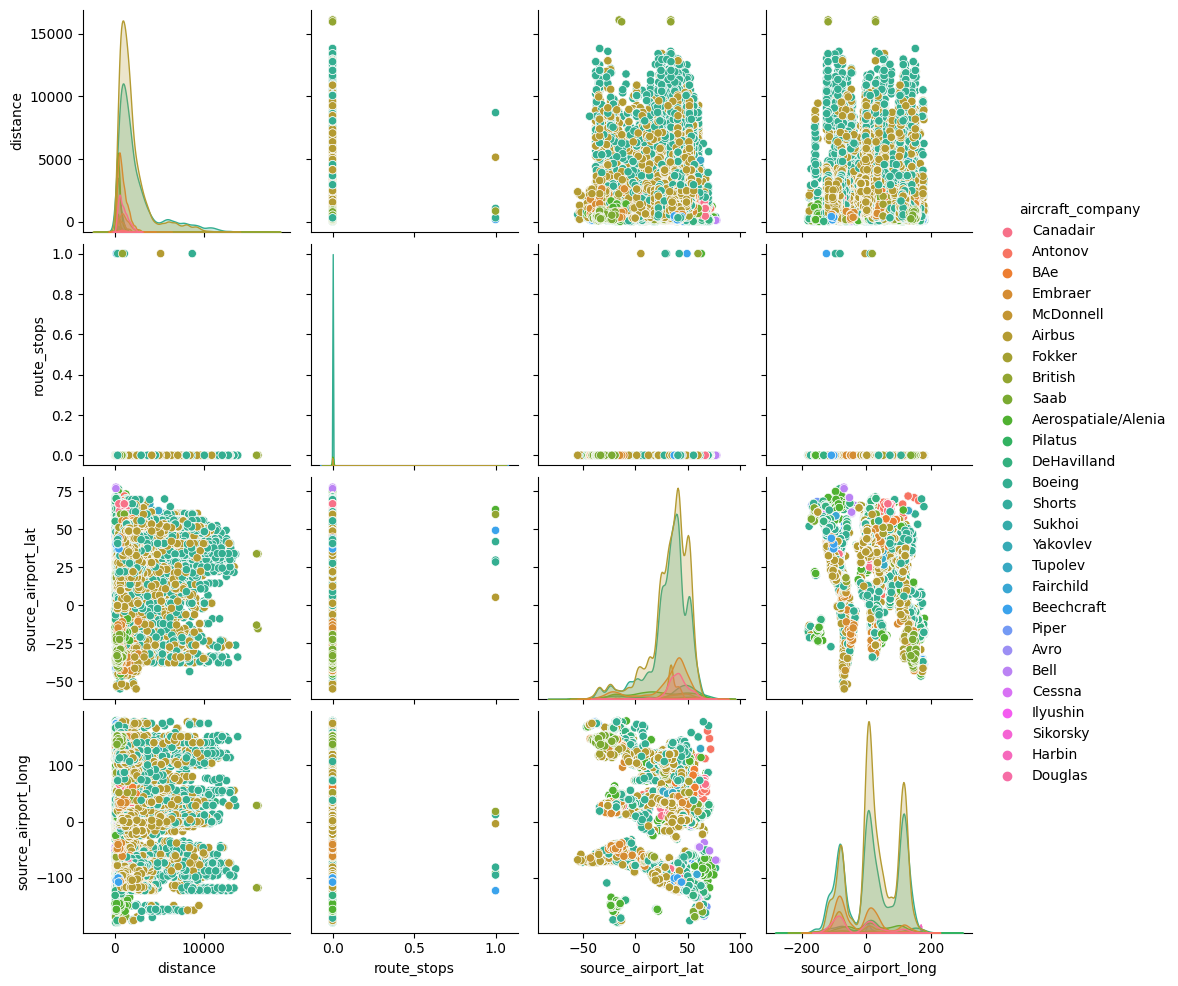

In [22]:
sns.pairplot(data, vars= ['distance','route_stops','source_airport_lat','source_airport_long'], hue='aircraft_company')

These sploms produce similar results to what has been previously analyzed, and uncover no new insights. Considering that there aren't many flights with 1 stop, this visualization isn't particularly helpful. It's possible to see that the world seems to have more airports in the northern hemisphere, but this data would all be more useful drilled down from a global perspective. The distance variable has otherwise been analyzed thoroughly previously in our analysis.